# Generate single-cell crops from Varchamp images

Purpose is to crop and format the Varchamp images and metadata to match the input for cytoself. 

In [1]:
# Imports
import polars as pl
import os
from pathlib import Path
from pprint import pprint
from tqdm import tqdm

In [56]:
# Paths
varchamp_dir = "/dgx1nas1/storage/data/jess/cytoself/varchamp_data"
imagecsv_dir = f"{varchamp_dir}/image_csv/cpg0020-varchamp/broad/workspace/assaydev/2024_01_23_Batch_7"
prof_path = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet"
img_dir = f"{varchamp_dir}/tiff_images"

## Filter Cells

In [47]:
# Get metadata
profiles = pl.scan_parquet(prof_path).select(
    ['Metadata_well_position', 'Metadata_plate_map_name', 'Metadata_ImageNumber', 'Metadata_ObjectNumber', 'Metadata_symbol', 'Metadata_gene_allele', 'Metadata_control_type', 'Metadata_Plate', 
    'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Cells_Intensity_MedianIntensity_GFP', 'Cells_Intensity_IntegratedIntensity_GFP']
).collect()
profiles.shape

(1866461, 14)

In [48]:
# Filter based on cell to nucleus area
profiles = profiles.with_columns(
                (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area"),
                pl.concat_str(['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber', 'Metadata_ObjectNumber'], separator="_").alias("Metadata_CellID")
        ).filter((pl.col("Nucleus_Cell_Area") > 0.15) & (pl.col("Nucleus_Cell_Area") < 0.3))
profiles.shape

(1256972, 16)

In [49]:
# Filter cells too close to image edge
profiles = profiles.filter(
    (pl.col("Nuclei_AreaShape_Center_X") > 50) & (pl.col("Nuclei_AreaShape_Center_X") < 1030) & (pl.col("Nuclei_AreaShape_Center_Y") > 50) & (pl.col("Nuclei_AreaShape_Center_Y") < 1030)
)
profiles.shape

(1122944, 16)

In [50]:
# Calculate median and mad of gfp intensity for each allele
medians = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
    pl.col("Cells_Intensity_MedianIntensity_GFP").median().alias("WellIntensityMedian")
)

profiles = profiles.join(medians, on=["Metadata_Plate", "Metadata_well_position"])

profiles = profiles.with_columns(
    (pl.col("Cells_Intensity_MedianIntensity_GFP") - pl.col("WellIntensityMedian")).abs().alias("Abs_dev")
)
mad = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
    pl.col("Abs_dev").median().alias("Intensity_MAD")
)
profiles = profiles.join(mad, on=["Metadata_Plate", "Metadata_well_position"])

# Threshold is 5X
profiles = profiles.with_columns(
    (pl.col("WellIntensityMedian") + 5*pl.col("Intensity_MAD")).alias("Intensity_upper_threshold"),
    (pl.col("WellIntensityMedian") - 5*pl.col("Intensity_MAD")).alias("Intensity_lower_threshold")
)

In [53]:
# Filter by intensity MAD
profiles = profiles.filter(
    pl.col("Cells_Intensity_MedianIntensity_GFP") <= pl.col("Intensity_upper_threshold")
).filter(
    pl.col("Cells_Intensity_MedianIntensity_GFP") >= pl.col("Intensity_lower_threshold")
)
profiles.shape

(1037703, 21)

## Explore MAD-based filter to remove cells with saturated GFP

From the plots below, a sensible cut-off seems like +- 5*MAD from the median.

In [36]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab, scale_x_log10, geom_vline

def gfpDistribution(dat: pl.DataFrame, gene_allele: str, plate: str = "all", well: str = "all", var = "Cells_Intensity_MedianIntensity_GFP"):
    dat = dat.filter(pl.col("Metadata_gene_allele") == gene_allele)

    median = dat.select(var).median().item()
    mad = dat.with_columns(
        (pl.col(var) - median).abs().alias("abs_deviation")
    ).select("abs_deviation").median().item()

    if plate != "all":
        dat = dat.filter(pl.col("Metadata_Plate") == plate)
    
    if well != "all":
        dat = dat.filter(pl.col("Metadata_well_position") == well)

    plot1 = (ggplot(dat) 
        + aes(x = var)
        + geom_histogram(bins=50)
        + geom_vline(xintercept = median, color = "blue")
        + geom_vline(xintercept = median + 5*mad, color = "red")
        + theme_bw()
        + scale_x_log10()
        + xlab("Median protein intensity (cell-level)"))

    plot1.show()

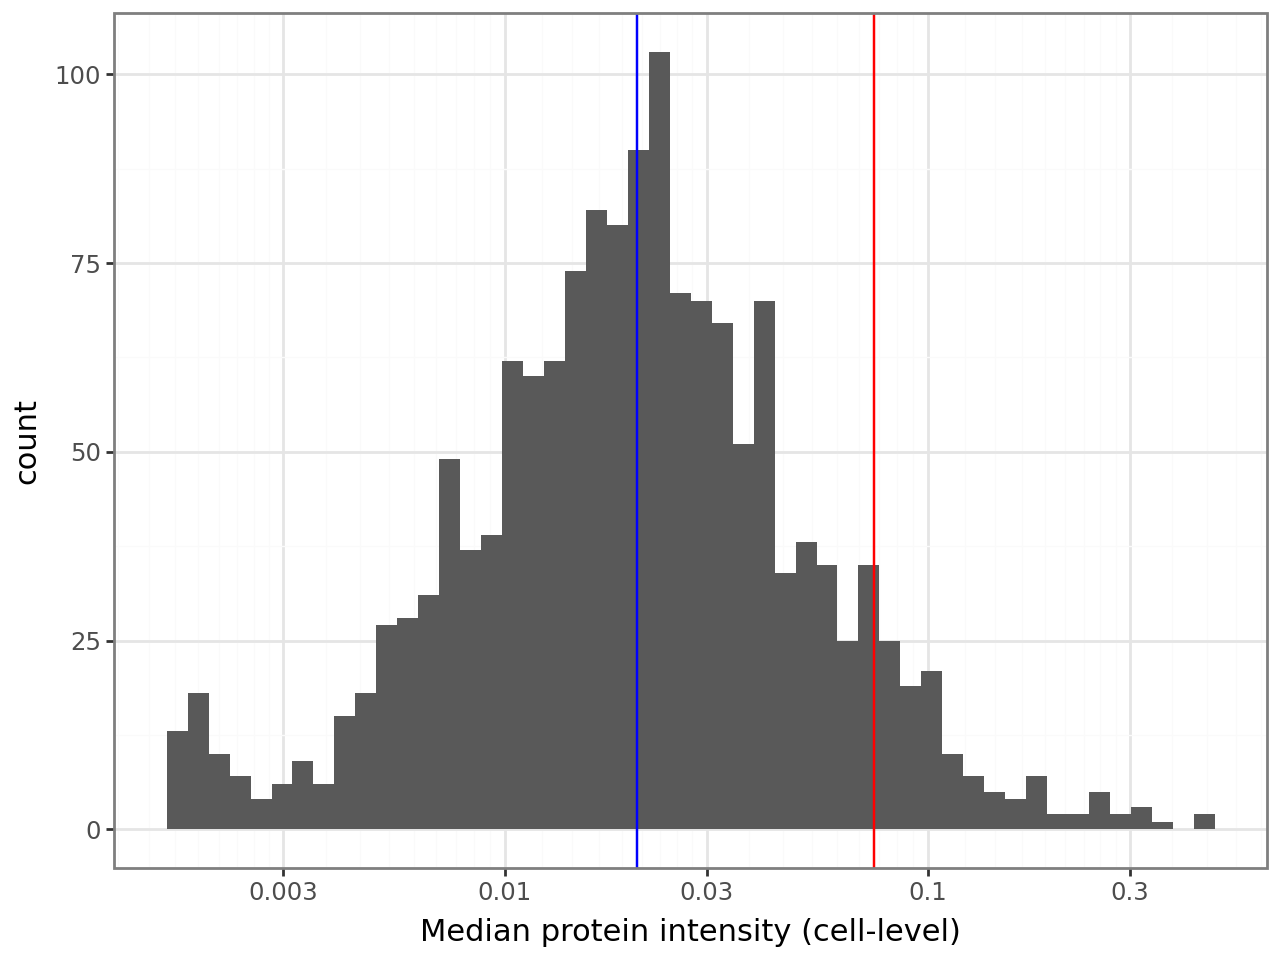

In [37]:
gfpDistribution(profiles, "FBP1")

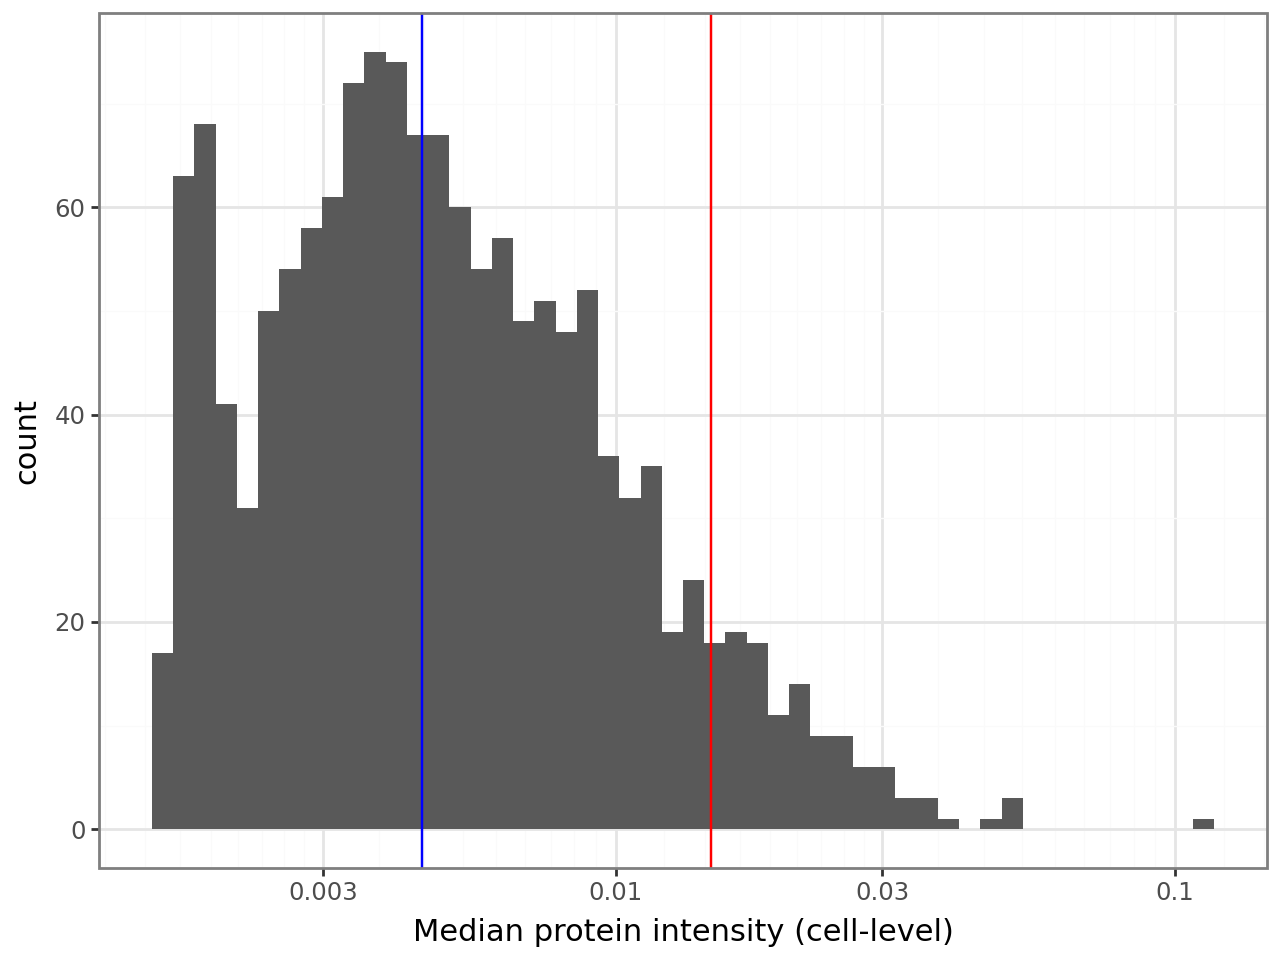

In [38]:
gfpDistribution(profiles, "MIP_Val67Ile")

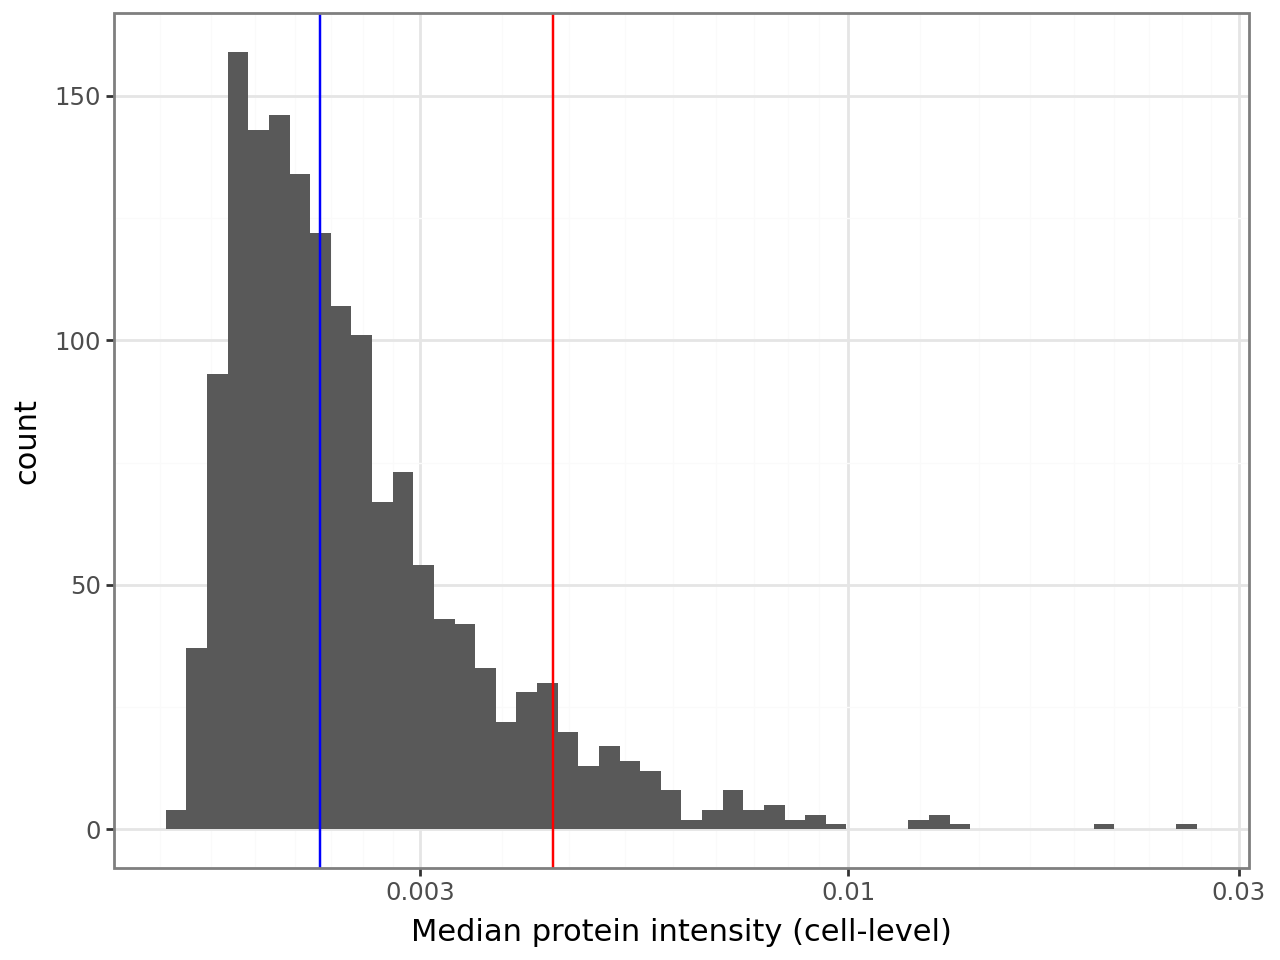

In [39]:
gfpDistribution(profiles, "MLH1_Ile36Asn")

## Process images and metadata

In [ ]:
# Read in all Image.csv to get ImageNumber:SiteNumber mapping and paths
image_dat = []
icf = os.listdir(imagecsv_dir)
for fp in tqdm(icf):
    plate, well = fp.split("-")

    image_dat.append(pl.read_csv(f"{imagecsv_dir}/{fp}/Image.csv").select(
        [
            'ImageNumber',
            'Metadata_Site',
            'PathName_OrigDNA',
            'PathName_OrigGFP',
            'FileName_OrigDNA',
            'FileName_OrigGFP'
            ]
        ).with_columns(
        pl.lit(plate).alias("Metadata_Plate"),
        pl.lit(well).alias("Metadata_well_position")
        ))
image_dat = pl.concat(image_dat).rename({"ImageNumber": "Metadata_ImageNumber"})

In [ ]:
# Create useful filepaths

In [ ]:
# Append to profiles

In [19]:
# Sort by gene, then allele, then plate, then well position, then image number
profiles = profiles.with_columns(
    pl.concat_str(['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber'], separator="_").alias("Metadata_ImageID")
)
profiles = profiles.sort(['Metadata_symbol', 'Metadata_gene_allele', 'Metadata_ImageID'])

56912

In [22]:
print(profiles.select(['Metadata_control_type', 'Metadata_symbol', 'Metadata_gene_allele', 'Metadata_ImageNumber', 'Metadata_Plate', 'Metadata_ImageID']))

shape: (1_122_944, 6)
┌────────────────┬────────────────┬────────────────┬───────────────┬───────────────┬───────────────┐
│ Metadata_contr ┆ Metadata_symbo ┆ Metadata_gene_ ┆ Metadata_Imag ┆ Metadata_Plat ┆ Metadata_Imag │
│ ol_type        ┆ l              ┆ allele         ┆ eNumber       ┆ e             ┆ eID           │
│ ---            ┆ ---            ┆ ---            ┆ ---           ┆ ---           ┆ ---           │
│ str            ┆ str            ┆ str            ┆ i64           ┆ str           ┆ str           │
╞════════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ disease_wt     ┆ null           ┆ null           ┆ 855           ┆ 2024_01_19_B7 ┆ 2024_01_19_B7 │
│                ┆                ┆                ┆               ┆ A1R1_P4T1     ┆ A1R1_P4T1_D23 │
│                ┆                ┆                ┆               ┆               ┆ _855          │
│ disease_wt     ┆ null           ┆ null           ┆ 2557          ┆ 

In [ ]:
# Get metadata for: nuclei centers, paths to images for DAPI and GFP

# Sort metadata by allele and then by image

# For each image - read into memory, generate SC crops for all cells in that image, rescale intensity using comparable methods to cytoself
# For each protein, append cropped images and metadata to numpy arrays in memory, then write out to a 'data_varchamp' folder

# For now, use all alleles but for full dataset may want to just train on WT and infer embeddings for all variants